<a href="https://colab.research.google.com/github/Diegosup/Celeb-GAN-generator/blob/main/GAN_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torchvision.utils as TVU
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
import PIL
%matplotlib inline

Important variables

In [ ]:
seed = 33
num_workers = 2
batch_size = 128
image_size = 64
channels = 3
latent_size = 100
featuremap_gen = 64
featuremap_dis = 64
ngpu = 1

In [ ]:
lr = 0.00015
beta_01 = 0.5

In [ ]:
image_folder =  "/content/drive/MyDrive/Colab Notebooks1/celebA_images"
images_list = list(os.listdir(image_folder))
rand_images = (random.choices(images_list, k=6))

In [ ]:
def view_image_examples(filename_list, image_folder, size=250):
    for image in filename_list:
        img = PIL.Image.open(image_folder + '/' + image)
        new_size = (size, size)
        img = TF.resize(img, size=size, max_size=size+100)
        transform = T.CenterCrop(size)
        img = transform(img)
        display(img)
        print('')

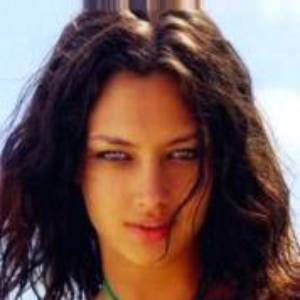

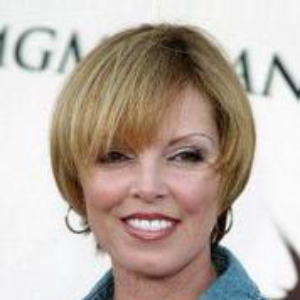

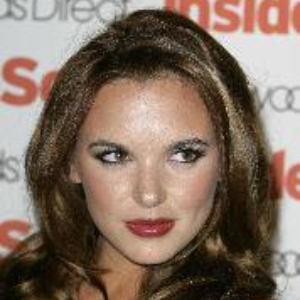

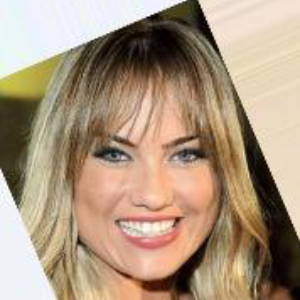

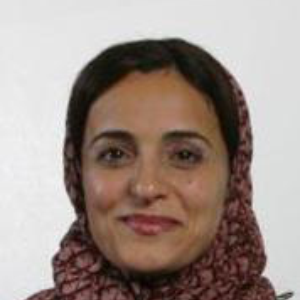

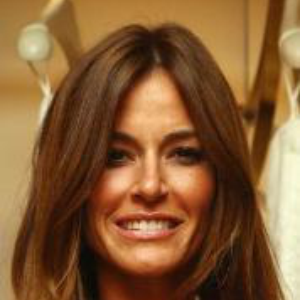

In [ ]:
view_image_examples(rand_images, image_folder, size=300)

In [ ]:
transforms = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
dataset = Dataset.ImageFolder(root = '/content/drive/MyDrive/Colab Notebooks1',
                              transform = transforms)

In [ ]:
loader = torch.utils.data.DataLoader(dataset,
                                     batch_size = batch_size,
                                     shuffle = True,
                                     num_workers = num_workers)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

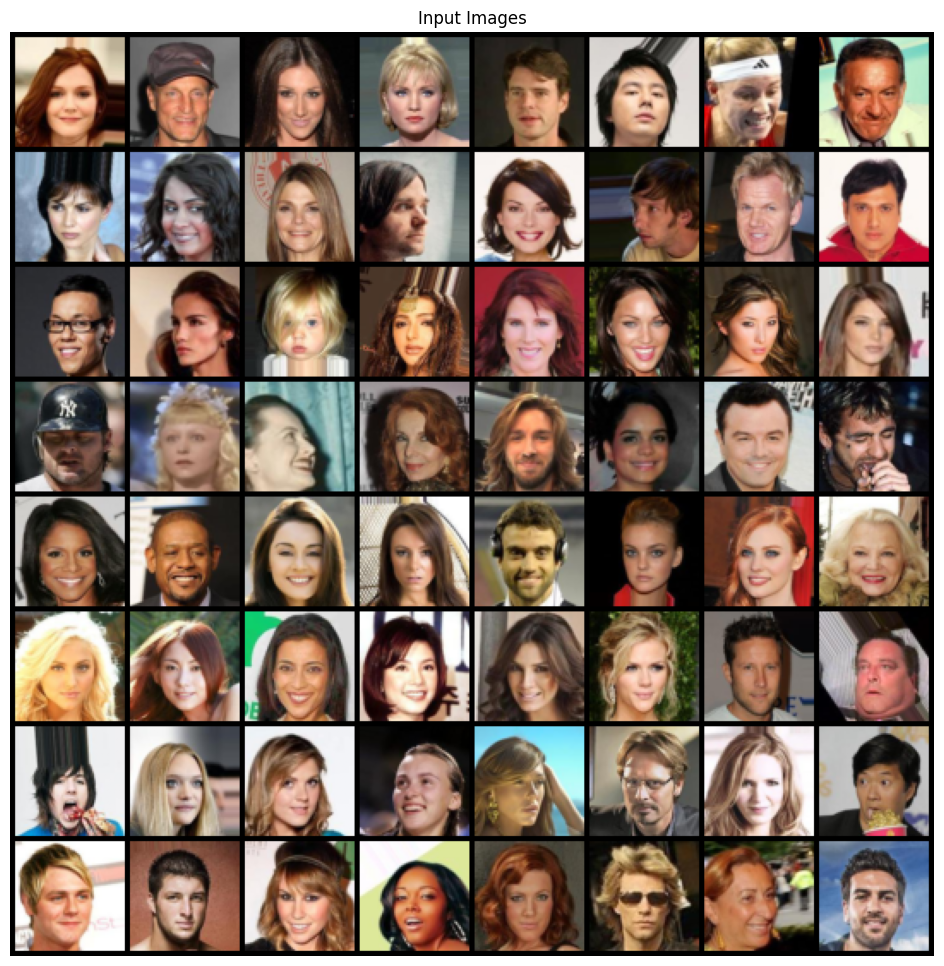

In [ ]:
input_batch = next(iter(loader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Input Images")
plt.imshow(np.transpose(TVU.make_grid(input_batch[0].to(device)[:64], padding=3, normalize=True).cpu(), (1,2,0)));

In [ ]:
def initialize_weights(model):
  classname = model.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(model.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(model.weight.data, 1.0, 0.02)
    nn.init.constant_(model.bias.data, 0)

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        nn.ConvTranspose2d(latent_size, featuremap_gen * 8,
                           4, 1, 0, bias = False),
        nn.BatchNorm2d(featuremap_gen * 8),
        nn.ReLU(True),

        nn.ConvTranspose2d(featuremap_gen * 8, featuremap_gen * 4, 
                           4, 2, 1, bias = False),
        nn.BatchNorm2d(featuremap_gen * 4),
        nn.ReLU(True),

        nn.ConvTranspose2d(featuremap_gen * 4, featuremap_gen * 2, 
                           4, 2, 1, bias = False),
        nn.BatchNorm2d(featuremap_gen * 2),
        nn.ReLU(True),

        nn.ConvTranspose2d(featuremap_gen * 2, featuremap_gen, 4, 2, 1,
                           bias = False),
        nn.BatchNorm2d(featuremap_gen),
        nn.ReLU(True),

        nn.ConvTranspose2d(featuremap_gen, channels, 4, 2, 1, bias = False),
        nn.Tanh())
    

  def forward(self, input):
    return self.main(input)

In [ ]:
happy_generator = Generator(ngpu).to(device)
happy_generator.apply(initialize_weights)
happy_generator.load_state_dict(torch.load('/content/drive/MyDrive/IA/checkpoints/celebs_generator.pth'))
print(happy_generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(channels, featuremap_dis,
                               4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(featuremap_dis, featuremap_dis * 2, 4, 2, 1, 
                      bias = False),
            nn.BatchNorm2d(featuremap_dis * 2),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(featuremap_dis * 2, featuremap_dis * 4, 
                      4, 2, 1, bias = False),
            nn.BatchNorm2d(featuremap_dis * 4),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(featuremap_dis * 4, featuremap_dis * 8, 4, 2, 1, 
                      bias = False),
            nn.BatchNorm2d(featuremap_dis * 8),
            nn.LeakyReLU(0.2, inplace = True),

            nn.Conv2d(featuremap_dis * 8, 1, 4, 1, 0, bias = False),
            nn.Sigmoid())


    def forward(self, input):
        return self.main(input)

In [ ]:
snarky_discriminator = Discriminator(ngpu).to(device)
snarky_discriminator.apply(initialize_weights)
snarky_discriminator.load_state_dict(torch.load('/content/drive/MyDrive/IA/checkpoints/celebs_discriminator.pth'))
print(snarky_discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
def save_samples(index, latent_tensors, generator, show=True):
    from torchvision.utils import save_image
    sample_dir = '/content/drive/MyDrive/IA/generated'
    os.makedirs(sample_dir, exist_ok=True)
    fake_images = generator(latent_tensors)
    fake_filename = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_filename), nrow=13)
    print(f'Your fake images are being saved as {fake_filename} in your directory')
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
loss_function = nn.BCELoss()
static_noise = torch.randn(64, latent_size, 1, 1, device=device)

label_real = 1.
label_fake = 0.

optimizer_dis = optim.Adam(snarky_discriminator.parameters(), lr = lr, betas = (beta_01, 0.999))
optimizer_gen = optim.Adam(happy_generator.parameters(), lr = lr, betas = (beta_01, 0.999))

In [ ]:
def train_models(num_epochs, dataloader, label_real, label_fake, discriminator, generator):
  image_list = []
  gen_loss = []
  dis_loss = []
  iterations = 0

  print("___________________________________Initiating Training Sequence____________________________________")
  print("")
  print('Epoch No.\t| Step No.\t\t| Generator Loss\t| Discriminator Loss\t| Avg Real')
  print("___________________________________________________________________________________________________")

  for epoch in range(num_epochs):
    for item, data in enumerate(dataloader, 0):
        
      # Training with original, real images
      discriminator.zero_grad()
      real_cpu = data[0].to(device)
      batch = real_cpu.size(0)
      label = torch.full((batch,), label_real, dtype = torch.float, device = device)
      output = discriminator(real_cpu).view(-1)
      dis_error_real = loss_function(output, label)
      dis_error_real.backward()
      avg_output_real = output.mean().item()

      # Training with generated, fake images
      static_noise = torch.randn(batch, latent_size, 1, 1, device=device)
      fake_results = generator(static_noise)
      label.fill_(label_fake)
      output = discriminator(fake_results.detach()).view(-1)
      dis_error_fake = loss_function(output, label)
      dis_error_fake.backward()
      gradients_sum_01 = output.mean().item()
      dis_error_overall = dis_error_real + dis_error_fake
      optimizer_dis.step()

      # Updating generator based on discriminator's results
      generator.zero_grad()
      label.fill_(label_real)
      output = discriminator(fake_results).view(-1)
      gen_error = loss_function(output, label)
      gen_error.backward()
      gradient_sum_02 = output.mean().item()
      optimizer_gen.step()

      if (item % 500 == 0) and (item > 0):
          print(f'[ {epoch+1} / {num_epochs} ]\t| [ {item} / {len(dataloader)} ]\t|{gen_error: .4f}\t\t| {dis_error_overall: .4f}\t\t|{avg_output_real: .4f}')
      
      gen_loss.append(gen_error.item())
      dis_loss.append(dis_error_overall.item())

      if (iterations % 500 == 0) or ((epoch == num_epochs - 1) and (item == len(dataloader) - 1)):
          with torch.no_grad():
              fake = generator(static_noise).detach().cpu()
          image_list.append(TVU.make_grid(fake, padding=3, normalize=True))
      
      iterations += 1
    save_samples(epoch+1, static_noise, generator = happy_generator, show = False)
  
  return gen_loss, dis_loss, image_list

In [ ]:
generator_loss, discriminator_loss, images = train_models(num_epochs = 200, 
                                                          dataloader = loader, 
                                                          label_real = label_real, 
                                                          label_fake = label_fake, 
                                                          discriminator = snarky_discriminator, 
                                                          generator = happy_generator)

___________________________________Initiating Training Sequence____________________________________

Epoch No.	| Step No.		| Generator Loss	| Discriminator Loss	| Avg Real
___________________________________________________________________________________________________
Your fake images are being saved as generated-images-0001.png in your directory
Your fake images are being saved as generated-images-0002.png in your directory
Your fake images are being saved as generated-images-0003.png in your directory
Your fake images are being saved as generated-images-0004.png in your directory
Your fake images are being saved as generated-images-0005.png in your directory
Your fake images are being saved as generated-images-0006.png in your directory
Your fake images are being saved as generated-images-0007.png in your directory
Your fake images are being saved as generated-images-0008.png in your directory
Your fake images are being saved as generated-images-0009.png in your directory
Your fak

In [ ]:
def plot_losses(generator_losses, discriminator_losses):
  plt.figure(figsize = (9, 6), facecolor = "#444444")
  plt.title("Training Loss: Generator and Discriminator", pad = 20, size = 18, color = 'white')
  plt.plot(generator_losses, label = "Generator");
  plt.plot(discriminator_losses, label = "Discriminator");
  plt.xlabel("Epochs", color = 'white', size = 16)
  plt.ylabel("Loss", color = 'white', size = 16)
  plt.xticks(color = 'white')
  plt.yticks(color = 'white')
  plt.legend()
  plt.show()

In [ ]:
plot_losses(generator_loss, discriminator_loss)

In [ ]:
fig = plt.figure(figsize=(9,9))
plt.axis("off")
plot_images = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in images]
celebrity_animation = ani.ArtistAnimation(fig, plot_images, interval=1000, repeat_delay=1000, blit=True)

HTML(celebrity_animation.to_jshtml())

In [ ]:
def real_v_fake(dataloader, image_list):
  batch_real = next(iter(dataloader))

  plt.figure(figsize = (12, 12))
  plt.subplot(1, 2, 1)
  plt.axis("off")
  plt.title("Real / Input Images")
  plt.imshow(np.transpose(TVU.make_grid(batch_real[0].to(device)[:64], 
                                        padding = 3, normalize = True).cpu(), 
                                        (1, 2, 0)))
  
  plt.subplot(1, 2, 2)
  plt.axis("off")
  plt.title("Fake / Generated Images")
  plt.imshow(np.transpose(image_list[-1], (1, 2, 0)))
  plt.show()

In [ ]:
real_v_fake(loader, images)

In [ ]:
torch.save(happy_generator.state_dict(), '/content/drive/MyDrive/IA/checkpoints/celebs_generator.pth')
torch.save(snarky_discriminator.state_dict(), '/content/drive/MyDrive/IA/checkpoints/celebs_discriminator.pth')

In [ ]:
# Save the model checkpoints 
#torch.save(happy_generator.state_dict(), '/content/drive/MyDrive/IA/models/Generator_celebrities.pth')
#torch.save(snarky_discriminator.state_dict(), '/content/drive/MyDrive/IA/models/Discriminator_celebrities.pth')